# Petals To Metals


Group 6 

Haritha Karna 

Venkata Himarohith Reddy Thammammuneni

In [1]:
import os
import re

import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Configurations

Here we set some of the configurations used for data processing.

In [2]:
IMG_SIZE = 192
BATCH_SIZE = 32
GCS_DS_PATH = KaggleDatasets().get_gcs_path("tpu-getting-started")
GCS_PATH = GCS_DS_PATH + f"/tfrecords-jpeg-{IMG_SIZE}x{IMG_SIZE}"
AUTO = tf.data.experimental.AUTOTUNE

TRAINING = tf.io.gfile.glob(GCS_PATH + "/train/*.tfrec")
VALIDATION = tf.io.gfile.glob(GCS_PATH + "/val/*.tfrec")
TEST = tf.io.gfile.glob(GCS_PATH + "/test/*.tfrec") 

CLASS = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

## Helper Functions

Helper functions for data processing.

In [3]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3]) # explicit size needed for TPU
    return image


def read_labeled_tfrecord(example):
    LABELED_TFREC = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, tf.one_hot(label, len(CLASS)) # returns a dataset of (image, label) pairs


def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)


def load_dataset(filenames, labeled: bool = True, ordered: bool = False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset


def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0, 2)
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.9)
    image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    return image, label   


def get_training():
    dataset = load_dataset(TRAINING, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset


def get_validation(ordered=False):
    dataset = load_dataset(VALIDATION, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset


def get_test(ordered=False):
    dataset = load_dataset(TEST, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset


def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    return sum(int(re.search(r"-([0-9]*)\.", x).group(1)) for x in filenames)


def get_model():
    backbone = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=[IMG_SIZE, IMG_SIZE, 3],
    )
    model = tf.keras.models.Sequential(
        [
            backbone,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASS), activation="softmax"),
        ]
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Load the Data

Discover all files, count samples, and create datasets.

In [4]:
training_images = count_data_items(TRAINING)
validation_images = count_data_items(VALIDATION)
test_images = count_data_items(TEST)

print(f"Number of training images:   {training_images:,d}.")
print(f"Number of validation images: {validation_images:,d}.")
print(f"Number of testing images:    {test_images:,d}.")

train_dataset = get_training()
val_dataset = get_validation()
test_dataset = get_test(ordered=True)

Number of training images:   12,753.
Number of validation images: 3,712.
Number of testing images:    7,382.


## Inspect the Data

Look at the random samples with the corresponding labels. Note that we are applying data augmentation, including random flips, rotation, hue/saturation, and brightness.

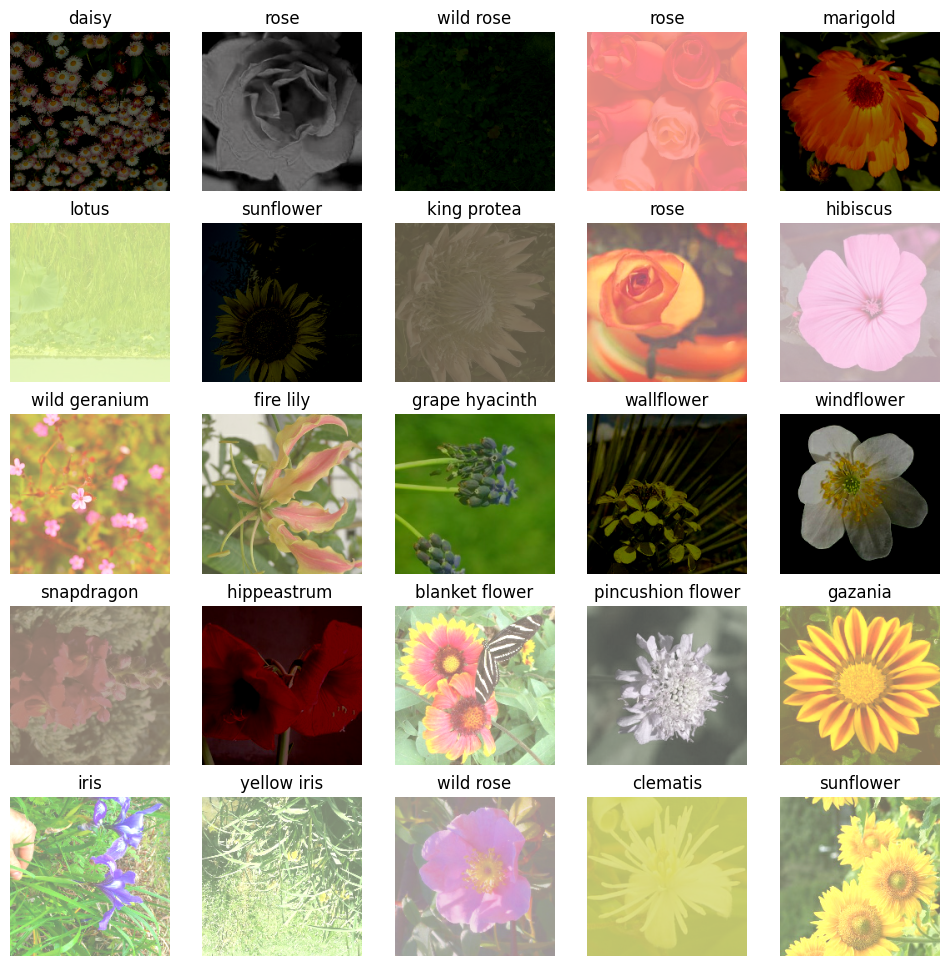

In [5]:
figure, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = [y for x in axes for y in x]

for i, sample in enumerate(train_dataset.unbatch().take(25).as_numpy_iterator()):
    axes[i].imshow(sample[0])
    
    flower = CLASS[tf.argmax(sample[1]).numpy()]
    axes[i].set_title(flower)
    axes[i].axis('off')

## Inspect the Model

Build the model and print the summary. We use the EfficientNetB0 model, the smallest in the [EfficientNet][efficientnet] family. We use ImageNet weights and use a lower learning rate with [Reduce LR on Plateau][reducelronlpateau] instead of freezing the model.

[efficientnet]: https://arxiv.org/abs/1905.11946
[reducelronlpateau]: https://keras.io/api/callbacks/reduce_lr_on_plateau

In [6]:
model = get_model()
model.summary()

16705208/16705208 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 6, 6, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 104)               133224    
                                                                 
Total params: 4,182,795
Trainable params: 4,140,772
Non-trainable params: 42,023
_________________________________________________________________


## Train the Model

Here we fit the model for a total of 20 epochs using Model Checkpointer and Reduce LR on Plateau callbacks. The weights of the best model are saved in the `model.h5` file.

In [7]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    steps_per_epoch=training_images // BATCH_SIZE,
    validation_steps=validation_images // BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            "model.h5", 
            monitor="val_accuracy",
            mode="max", 
            save_best_only=True,
            save_weights_only=True,
            verbose=1,
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            mode='max',
            patience=5,
            min_lr=1e-6,
            verbose=2,
        ),
    ],
    verbose=1 if os.environ["KERNEL_RUN_TYPE"] == "Interactive" else 2,
).history

Epoch 1/30


2023-11-01 23:28:58.913076: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


398/398 [==============================] - ETA: 0s - loss: 3.2611 - accuracy: 0.2837
Epoch 1: val_accuracy improved from -inf to 0.07705, saving model to model.h5
398/398 [==============================] - 134s 198ms/step - loss: 3.2611 - accuracy: 0.2837 - val_loss: 4.2015 - val_accuracy: 0.0770 - lr: 1.0000e-04
Epoch 2/30
398/398 [==============================] - ETA: 0s - loss: 1.6814 - accuracy: 0.5992
Epoch 2: val_accuracy improved from 0.07705 to 0.61719, saving model to model.h5
398/398 [==============================] - 70s 176ms/step - loss: 1.6814 - accuracy: 0.5992 - val_loss: 1.5186 - val_accuracy: 0.6172 - lr: 1.0000e-04
Epoch 3/30
398/398 [==============================] - ETA: 0s - loss: 1.1095 - accuracy: 0.7266
Epoch 3: val_accuracy did not improve from 0.61719
398/398 [==============================] - 70s 175ms/step - loss: 1.1095 - accuracy: 0.7266 - val_loss: 1.7847 - val_accuracy: 0.5334 - lr: 1.0000e-04
Epoch 4/30
398/398 [==============================] - ETA: 

## Learning Curves

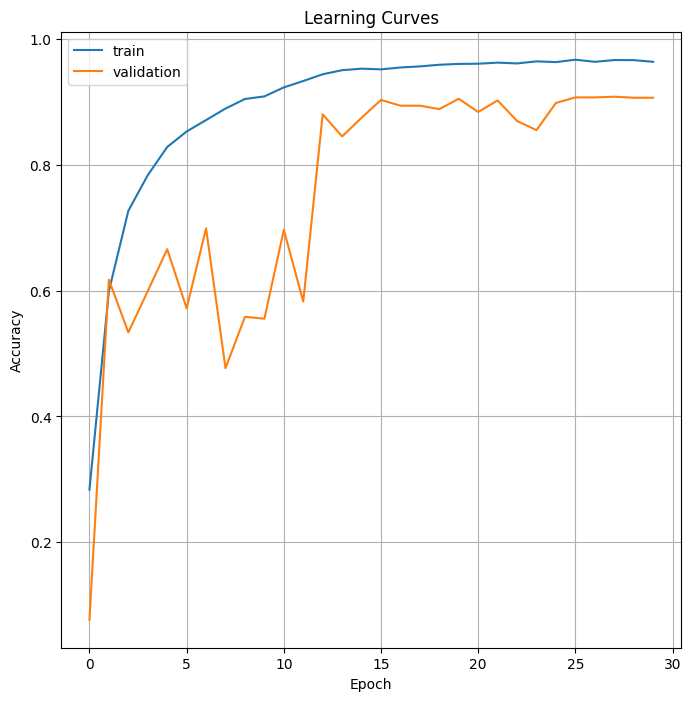

In [8]:
figure, axes = plt.subplots(1, 1, figsize=(8, 8))

epochs = list(range(len(history["loss"])))

axes.plot(epochs, history["accuracy"], label="train")
axes.plot(epochs, history["val_accuracy"], label="validation")
axes.set_title("Learning Curves")
axes.set_xlabel("Epoch")
axes.set_ylabel("Accuracy")
axes.legend()
axes.grid()

## Visualise Predictions

Finally, display some random samples from the validation set to visually assess model performance.

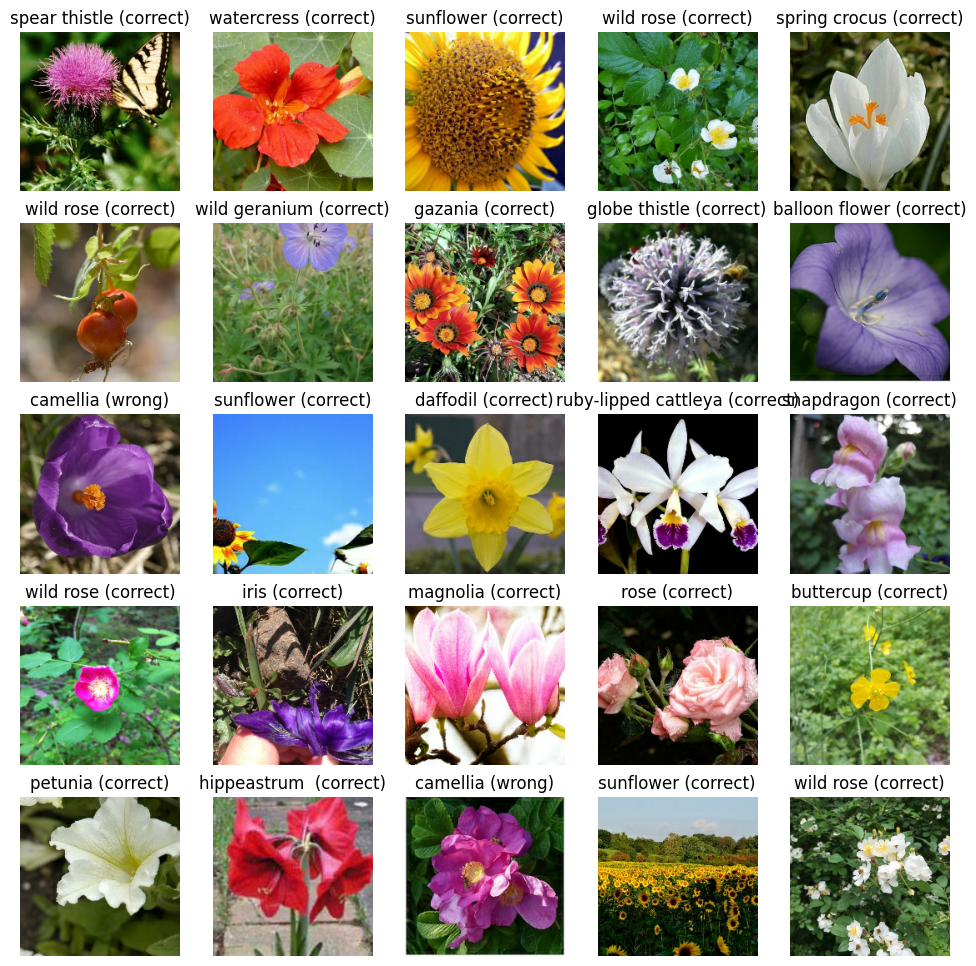

In [9]:
cons_data = val_dataset.unbatch().take(25).batch(25)
predicts = model.predict(cons_data, verbose=0)

figure, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = [y for x in axes for y in x]

for i, (sample, predict) in enumerate(zip(cons_data.unbatch().as_numpy_iterator(), predicts)):
    axes[i].imshow(sample[0])
    true = tf.argmax(sample[1]).numpy()
    predicted = tf.argmax(predict).numpy()
    correct = true == predicted
    axes[i].set_title(f"{CLASS[predict]} ({'correct' if correct else 'wrong'})")
    axes[i].axis("off")

## Save Submission File

Run the inference on the test dataset and save the model predictions in the `result.csv` file to submit the results to the competition.

In [10]:
predictions = model.predict(test_dataset, verbose=0)
predictions = tf.argmax(predictions, axis=-1)
ids = [id_.decode() for image, id_ in test_dataset.unbatch().as_numpy_iterator()]

result = pd.DataFrame(data={"id": ids, "label": predictions})
result.to_csv("result.csv", index=False)
result

,id,label
0,252d840db,67
1,1c4736dea,28
2,dfd946ac8,52
3,6e644aad3,49
4,0c3ae4377,81
...,...,...
7377,0cfca4a37,46
7378,47f47a868,80
7379,27c1d078f,18
7380,b9b88996b,94
